# Blind source separation (BSS) of maternal and fetal ECG using ICA

Before you start working, please install the wfdb package. Open anaconda prompt, activate bm-336546 and type `pip install wfdb`. Do not try to install the package through the notebook. Only if you work on GoogleColab, uncomment the following cell and run it:

In [1]:
# !pip install wfdb

BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [2]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the follwing figure are the "ECG" signals measured in different ECG leads.

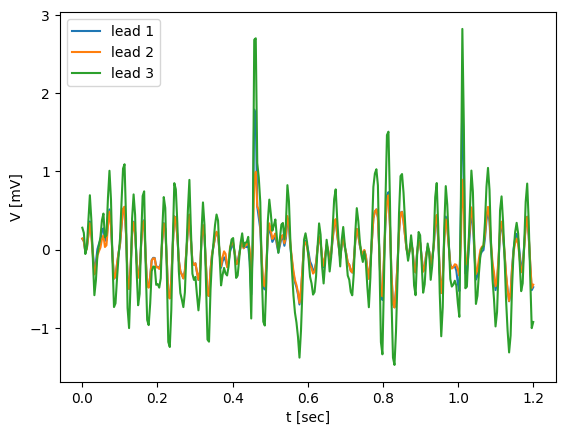

In [3]:
X = np.load('mixed_signals.npy')
Fs = 250 # [Hz],
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3X300}\right)$ can be written as $X=AS$ where $S\in R^{3X300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how is the whitening process relative to a machine learning algorithm that we already saw and mention what is the ML algorithm? Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:
The machine learning algorithm that we already learned and related to the whitening process is Principal Component Analysis (PCA). PCA is a technique for dimensionality reduction,feature extraction and source separation that involves identifying the principal components of the data, which are the linear combinations of the original features that capture the most variance in the data.
When performing PCA, the goal is to identify a new set of uncorrelated variables, called principal components, that capture the maximum amount of variance in the original data. Whitening the data prior to PCA can make the covariance matrix of the data an identity matrix-variance equals 1 for all features, which simplifies the computation of the principal components.
In addition,the whitening step in PCA can improve the performance by removing any linear correlations in the data and ensuring that each feature has equal variance. The whitened data can also simplify the interpretation of the principal components by removing scaling differences between the features.

Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ column vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [4]:
def whitening(X):
    #---------------------Implement your code here:------------------------
    mu_x = np.mean(X, axis=1,keepdims=True)
    X_centered = X - mu_x
    cov_matrix = np.cov(X_centered)
    eigen_vals, eigen_vecs = np.linalg.eigh(cov_matrix)
    lambda_matrix = np.diag(eigen_vals)
    lambda_matrix_inv_sqrt = np.sqrt(np.linalg.inv(lambda_matrix))
    X_whiten = lambda_matrix_inv_sqrt @ eigen_vecs.T @ X_centered
    #----------------------------------------------------------------------
    return X_whiten

We will now look at the covariance matrix of the whitened data:

In [5]:
X_w = whitening(X)
print(np.cov(X_w))

[[ 1.00000000e+00 -7.37901007e-14 -3.18437213e-15]
 [-7.37901007e-14  1.00000000e+00  4.89686329e-15]
 [-3.18437213e-15  4.89686329e-15  1.00000000e+00]]


Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:
yes this values matches our expectations.
The covariance matrix that was received is approximately the identity matrix - 1's on the diagonal and zeros outside of it.The 1's on the diagonal means that all features were normalized to variance of 1. Zeros or very small numbers that approach zero outside of the diagonal - indicating that the features are uncorrelated! and that's exactly what we wished to achieve in the whitening process-normalized uncorrelated features.

We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$: 


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}[x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})]^3 - 3w^{(p)}_{n-1}$ 

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ column of $W$ (the 3X3 matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [6]:
# def update_wp(w_p,X_w,W,p):
#     #---------------------Implement your code here:------------------------
#     wp_n = np.zeros((3,))
#     #step 2
#     for i in range(X_w.shape[1]): #300 , this loop is equal to the sum at step2
#         x = X_w[:,i] #i'th column of X_w
#         wp_n += ((x*(w_p.T@x))**3)/300
#     wp_n -= 3*w_p
#     #step 3
#     for j in range(p):
#         wp_n -= (w_p.T@W[:,j])*W[:,j]
#     #step 4
#     w_p = wp_n/np.linalg.norm(wp_n)
#     #----------------------------------------------------------------------
#     return w_p

In [7]:
def update_wp(w_p, X_w, W, p):
    #---------------------Implement your code here:------------------------
    # Step 2
    w_p = (1/300)*np.sum([(np.dot(X_w[:,i], np.dot(w_p, X_w[:,i]))**3) for i in range(X_w.shape[1])]) - 3*w_p
    # Step 3
    for j in range(p):
        w_p = w_p - np.dot(np.dot(w_p, W[j]), W[j])
    # Step 4
    w_p = w_p/np.linalg.norm(w_p)
    #----------------------------------------------------------------------
    return w_p

In [8]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results. 

In [9]:
#---------------------Implement your code here:------------------------
dot_product = W@(W.T)
print(np.allclose(dot_product, np.eye(3)))
print(np.allclose((W.T@W),np.eye(3)))
dot_product
#----------------------------------------------------------------------

True
True


array([[ 1.00000000e+00,  1.40430655e-14, -1.23043690e-13],
       [ 1.40430655e-14,  1.00000000e+00, -2.61248210e-17],
       [-1.23043690e-13, -2.61248210e-17,  1.00000000e+00]])

### Answer:
If W is orthonormal matrix then by defintion W*W.T=W.T*W should be equal the identity matrix, we can see that outside the diagonal we got approximate zeros but not exactly zero, this means that our reconstruction algoritem is not perfect , this may have happened for 3 main reasons :
first ,numerical calculations error and rounding errors. secondly , The algorithm assumes that the mixing functions are linear and invertible, but in practice, the mixing functions may be nonlinear or non-invertible. This means that the estimated sources may not perfectly match the original sources, resulting in imperfect reconstruction , and thirdly ,The algorithm assumes that the sources have a specific statistical distribution (i.e., non-Gaussian), and that the mixing matrix is full rank. If these assumptions are not met, the algorithm may not be able to separate the sources properly.

In [10]:
# Ground true sources for comparing later on
GT = np.load('groundtruth0.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

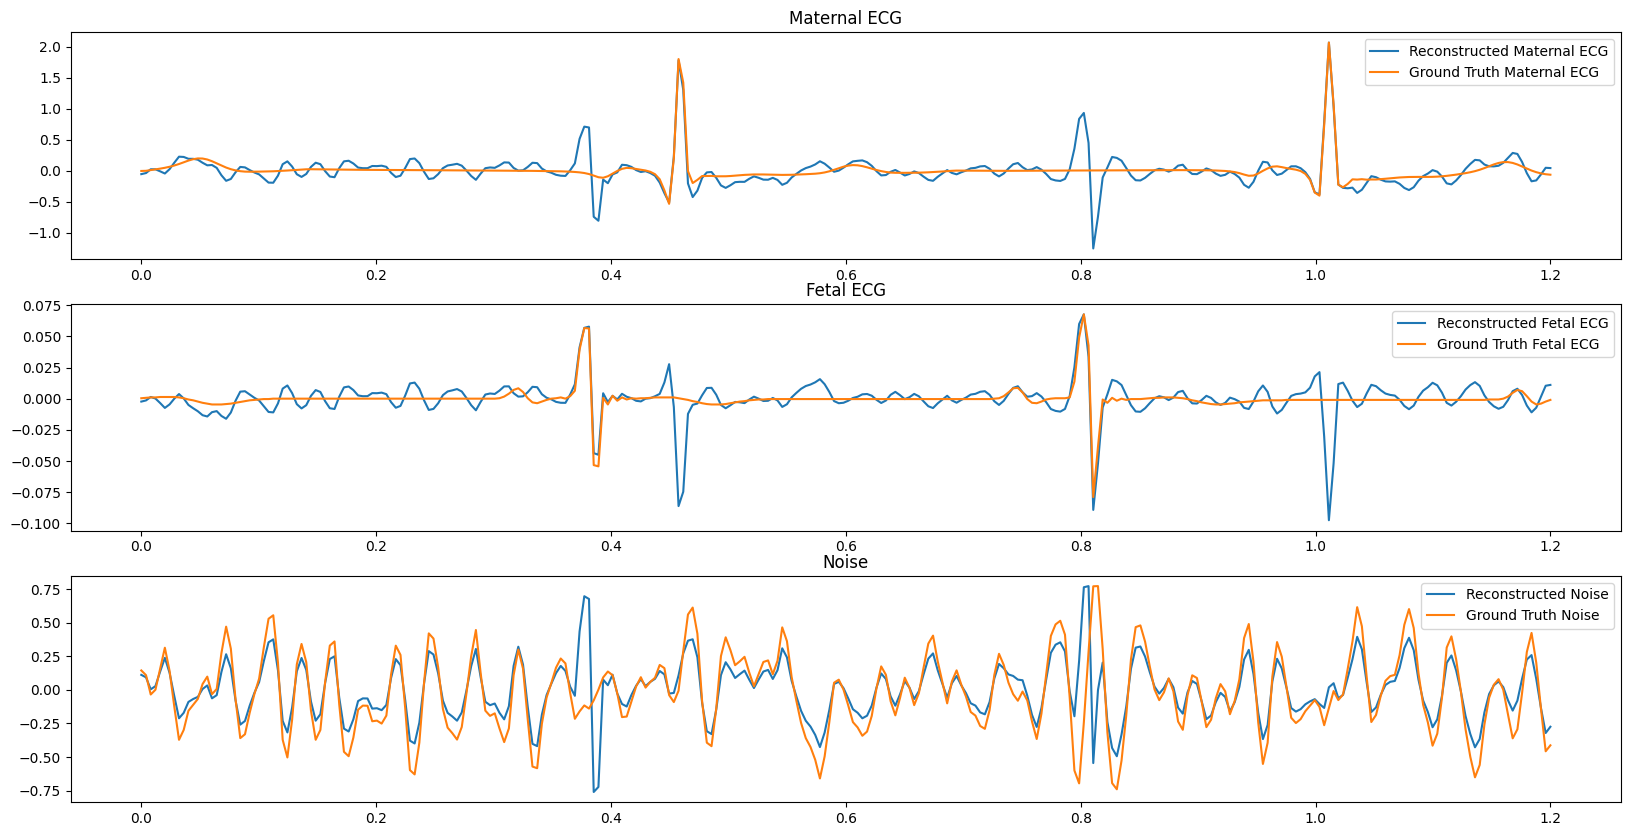

In [11]:
#---------------------Implement your code here:------------------------
# Reconstruct sources
S = np.dot(W.T, X_w)

# Getting the amplitudes to the same levels
S[0,:] = S[0,:]*(np.max(maternal_ecg)/np.max(S[0,:]))
S[1,:] = S[1,:]*(np.max(fetal_ecg)/np.max(S[1,:]))
S[2,:] = S[2,:]*(np.max(noise)/np.max(S[2,:]))

# Plot the reconstructed sources alongside the ground truth signals
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, S[0,:],  label='Reconstructed Maternal ECG')
plt.plot(t, maternal_ecg,  label='Ground Truth Maternal ECG')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S[1,:],  label='Reconstructed Fetal ECG')
plt.plot(t, fetal_ecg,  label='Ground Truth Fetal ECG')
plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S[2,:],  label='Reconstructed Noise')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.title('Noise')
plt.legend()
plt.show()
#----------------------------------------------------------------------


As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

In [12]:
from sklearn.decomposition import FastICA
#---------------------Implement your code here:------------------------
np.random.seed(42)
max_iter = 2000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
w_p = np.random.randn(n_component)
ICA = FastICA(n_components=n_component, max_iter=max_iter, tol=threshold, w_init=W)
ICA.fit(X)
ICA_trans = ICA.fit_transform(X)
S_sklearn = ICA.inverse_transform(ICA_trans)
#----------------------------------------------------------------------

C:\Users\rasht\miniconda3\envs\bm-336546\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\rasht\miniconda3\envs\bm-336546\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\rasht\miniconda3\envs\bm-336546\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\rasht\miniconda3\envs\bm-336546\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Plot and compare the results to what you did. You should have pretty similar results up to scaling factors.

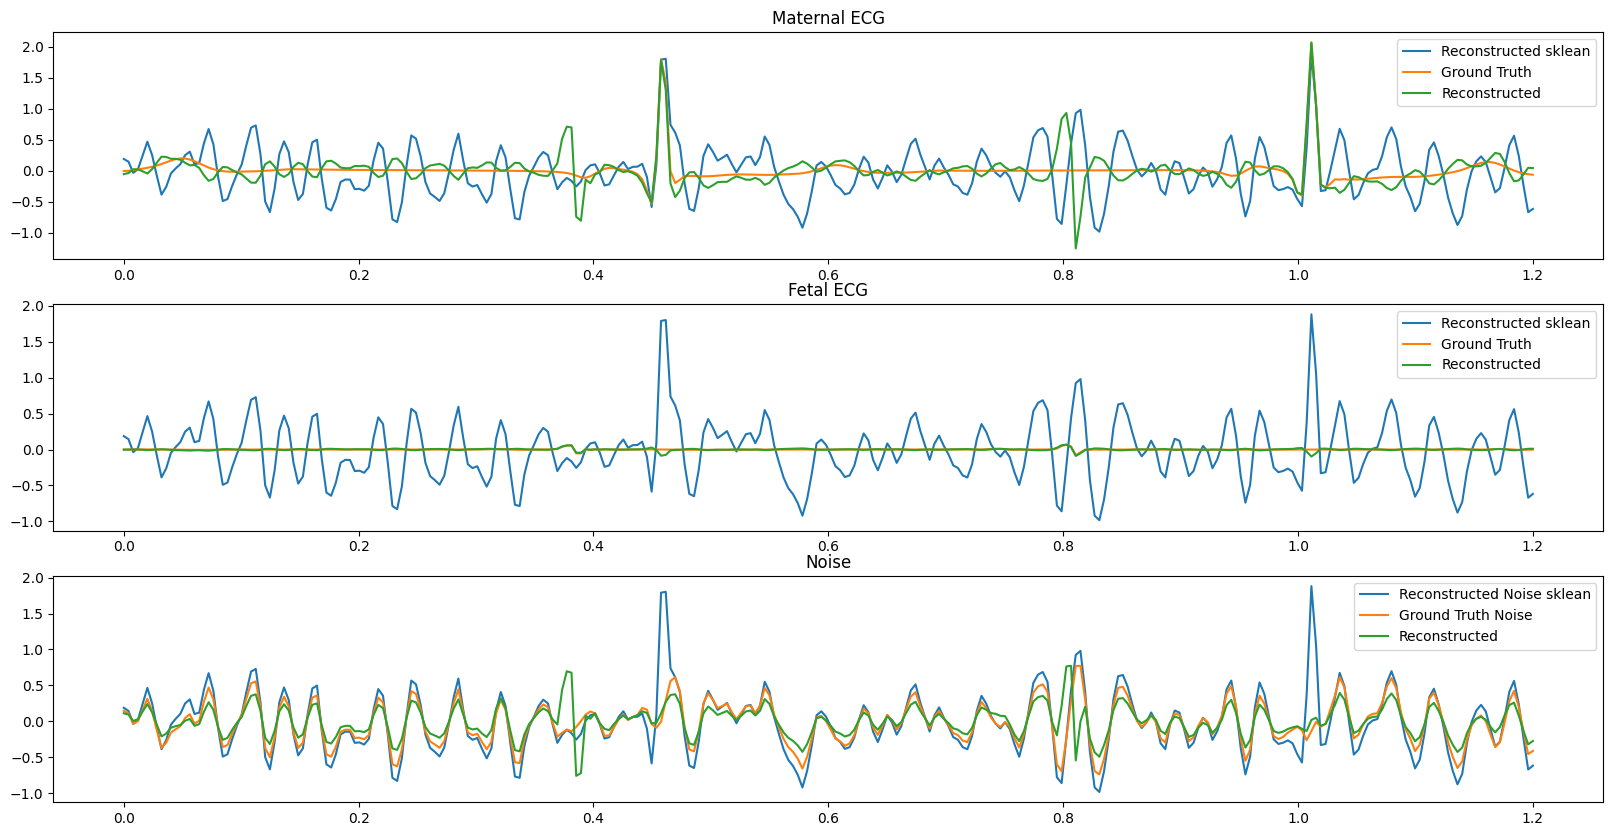

In [13]:
#---------------------Implement your code here:------------------------
# Plot the reconstructed sources alongside the ground truth signals
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, S_sklearn[0,:],  label='Reconstructed sklean')
plt.plot(t, maternal_ecg,  label='Ground Truth')
plt.plot(t, S[0,:],  label='Reconstructed')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S_sklearn[1,:],  label='Reconstructed sklean')
plt.plot(t, fetal_ecg,  label='Ground Truth ')
plt.plot(t, S[1,:],  label='Reconstructed')

plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S_sklearn[2,:],  label='Reconstructed Noise sklean')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.plot(t, S[2,:],  label='Reconstructed')

plt.title('Noise')
plt.legend()
plt.show()
#----------------------------------------------------------------------

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [14]:
X_clean = np.load('mixed_signal12.npy')
X_clean.shape

(3, 300)

We will run again the ICA.

In [15]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

These are the ground true measurements:

In [16]:
GT = np.load('groundtruth12.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above. 

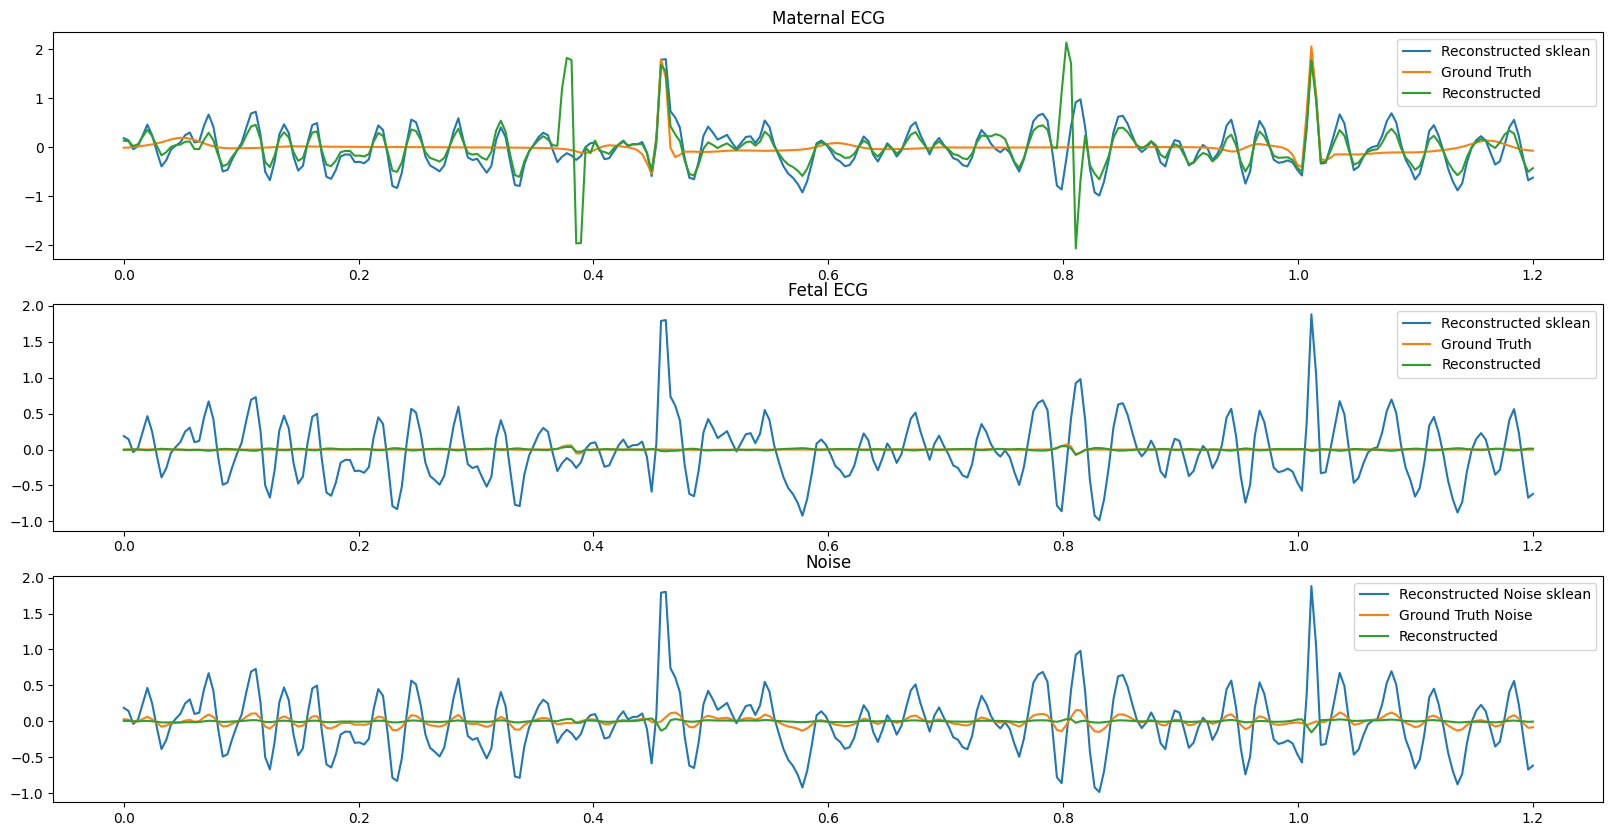

In [17]:
#---------------------Implement your code here:------------------------
# Plot the reconstructed sources alongside the ground truth signals
S = np.dot(W, X_w)
# change the amplitude according the new signals
#this time we need to flip the signals ! so will multiply by -1
maternal_recon = S[0,:]*(np.max(maternal_ecg)/np.max(S[0,:]))*-1
fetal_recon = S[1,:]*(np.max(fetal_ecg)/np.max(S[1,:]))*-1
noise_recon = S[2,:]*(np.max(noise)/np.max(S[2,:]))*-1


plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, S_sklearn[0,:],  label='Reconstructed sklean')
plt.plot(t, maternal_ecg,  label='Ground Truth')
plt.plot(t, maternal_recon,  label='Reconstructed')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S_sklearn[1,:],  label='Reconstructed sklean')
plt.plot(t, fetal_ecg,  label='Ground Truth ')
plt.plot(t, fetal_recon,  label='Reconstructed')

plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S_sklearn[2,:],  label='Reconstructed Noise sklean')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.plot(t, noise_recon,  label='Reconstructed')

plt.title('Noise')
plt.legend()
plt.show()
#----------------------------------------------------------------------

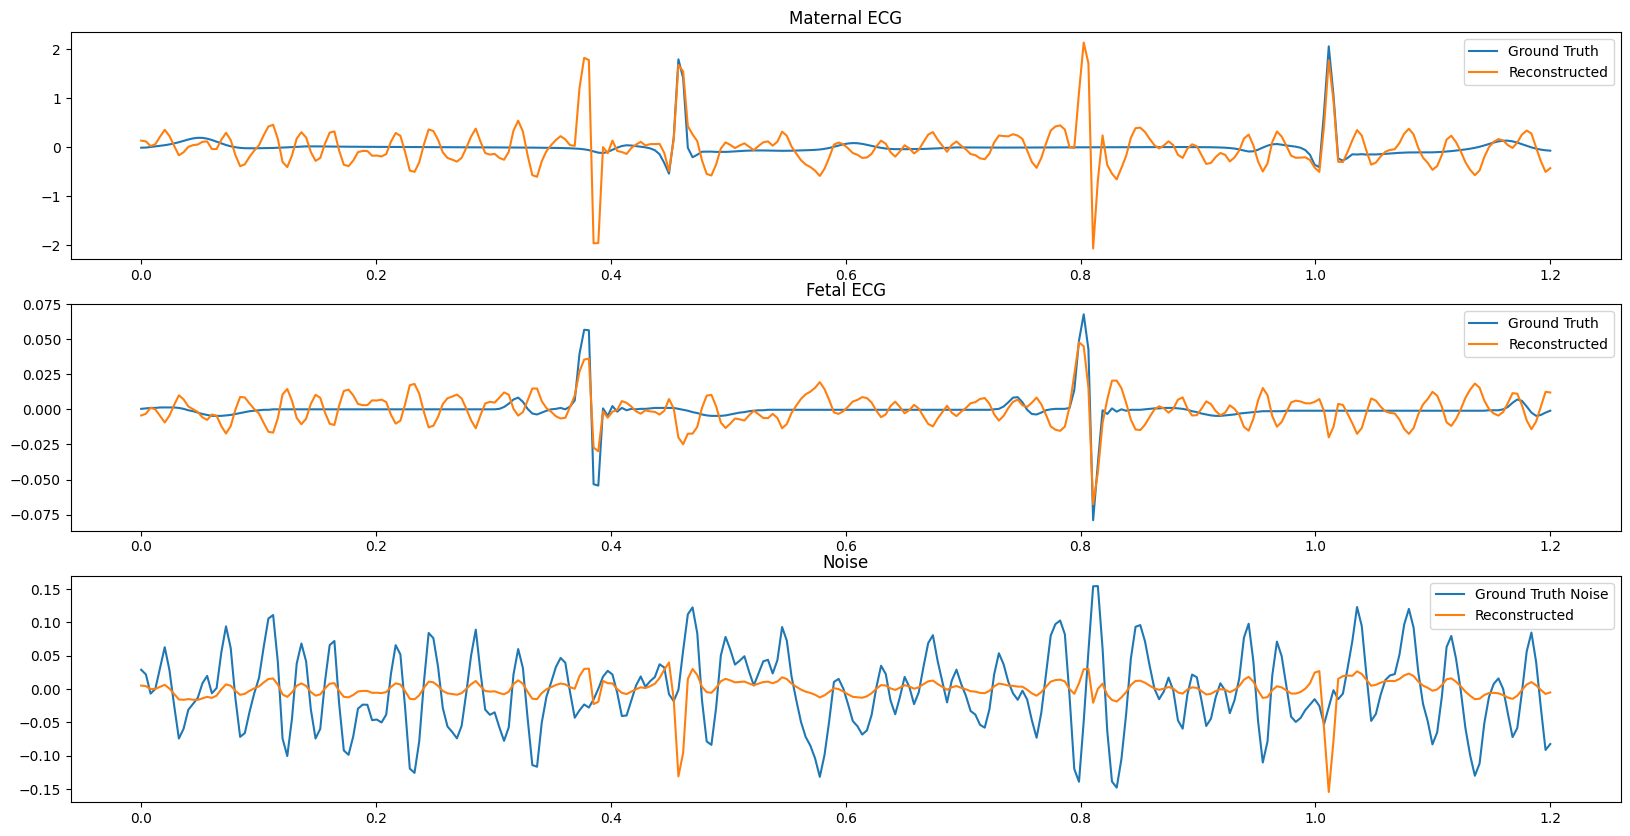

In [18]:
#---------------------Implement your code here:------------------------
#it's hard seeing with 3 plots so will plot again but only with our recon and GT
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.plot(t, maternal_ecg,  label='Ground Truth')
plt.plot(t, maternal_recon,  label='Reconstructed')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, fetal_ecg,  label='Ground Truth ')
plt.plot(t, fetal_recon,  label='Reconstructed')

plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, noise,  label='Ground Truth Noise')
plt.plot(t, noise_recon,  label='Reconstructed')

plt.title('Noise')
plt.legend()
plt.show()
#----------------------------------------------------------------------

Did you expect better recontructio with higher SNR. If it did not happen, what could possibly explain it?

## Answer:
When the Signal Noise Rastio(SNR) is higher, the signal is less contaminated with noise, which can result in a clearer and more accurate representation of the underlying sources , hence we expected to get a better reconstruction from the signal with the higher SNR , we can see that this is not what happened here,seems the reconstruction did not improve, we could possibly explain it by presence of nonlinear distortions or nonlinear mixing in the data that appear more on the higher SNR signal. In such cases, linear methods like ICA may not be able to capture the true underlying sources, resulting in worse reconstruction performance. Another possible reason are the limitations of the model we created , it is possible that we made some mathematical assumptions that may not be accurate and higher SNR made the affect of these errors more apparent .

GOOD LUCK!